# Анализ советов по профилактике выгорания.

На основе ответов на задание из телеграм-чата одной студенческой группы.

Загружаем необходимые библиотеки, в том числе и для анализа текста.

In [1]:
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt 
plt.rcdefaults()
import numpy as np
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.util import ngrams
pd.set_option('display.max_colwidth', None)
from pymystem3 import Mystem
import warnings
warnings.filterwarnings('ignore')

Сообщения из беседы в телеграме скачаны в json-формате. Тест сообщений находится в столбце `messages`.

In [2]:
data = pd.read_json('result.json')

df = data['messages'].copy()

Преобразуем данные в датафрейм и посмотрим на пару сообщений.

In [3]:
df = pd.DataFrame.from_dict(df)

In [4]:
df.sample(3, random_state = 4)

,messages
33,"{'id': 376833, 'type': 'message', 'date': '2020-12-24T20:09:11', 'from': 'Алина', 'from_id': 4549410669, 'file': '(File not included. Change data exporting settings to download.)', 'media_type': 'voice_message', 'mime_type': 'audio/ogg', 'duration_seconds': 28, 'text': ''}"
214,"{'id': 377145, 'type': 'message', 'date': '2020-12-25T18:50:47', 'from': 'Юля Сайдумарова', 'from_id': 4762084433, 'text': 'я ща буду выяснять за какой то период конечно'}"
39,"{'id': 376839, 'type': 'message', 'date': '2020-12-24T20:09:17', 'from': 'Юля Сайдумарова', 'from_id': 4762084433, 'forwarded_from': 'Oxana Marshakova', 'text': [{'type': 'hashtag', 'text': '#Задание_8'}, ' 5 способов восстановить мой ресурс. Пишу здесь те способы, которые актуальны для меня сейчас, в зимнее время. 1) Поспать. Я всегда была хороша в этом, и качественный сон мне 100% помогает восстановить силы и ресурсы. Особенно я стала ценить сон после того, как примерно 1,5 года не спала дольше 2-3 часов подряд. 2) Пособирать Lego вместе с сыном, а после игры в одиночестве сортировать детали по контейнерам. Я раньше и представить не могла, что это так медитативно! Да еще и мысли приводит в порядок, пока руки заняты. 3) Регулярно ходить в зал. Здорово отключает голову, особенно если это силовая тренировка. 4) Приготовить десерт вроде маффинов или пирога, а потом пить чай с семьей и смотреть кино. 5) Почитать книжку не по теме учебы, которую я долго выбирала, а потом до нее не доходили руки, потому что надо же читать психологию.']}"


Каждая строка является словарём, из которого нам нужно только значение поля `text`, к тому же не пустое.

Заметим, что не все имеющиеся сообщения явлются советами, поэтому нужно будет отфильтровать ненужные строки.

In [5]:
text = pd.DataFrame()
for i in range(df.shape[0]):
    if df.loc[i, 'messages']['text'] != '':
        text.loc[i, 'text'] = df.loc[i, 'messages']['text']

In [6]:
text = text.reset_index(drop = True)

In [7]:
text.sample(5, random_state = 42)

,text
55,дача видимо в пролете
40,"[{'type': 'hashtag', 'text': '#Задание_8'}, \n\nПрофилактика выгорания\n 1. Слушать любимую музыку\n 2. Смотреть фильмы, но только обязательно с позитивной концовкой 😂🙈\n 3. Много проводить времени на свежем воздухе, как можно больше ходить \n 4. Встречаться с близкими \n 5. Читать книги]"
19,но это так или иначе много у кого проявляется
31,"[{'type': 'hashtag', 'text': '#Задание_8'}, \n1) Хорошенько выспаться. Когда я сплю больше обычного, особенно если днем, мне снятся хорошие приключенческие сны - можно не платить за нетфликс)\n2) Потратить время на готовку ужина. Обычно мы с мужем готовим простые быстрые блюда или заказываем доставку - приготовление какого-нибудь сложного шедевра заряжает.\n3) Когда у меня сложный день на работе, и я не хочу ""нести"" это все домой, я включаю музыку в машине и громко пою. Это безопасно для ушей окружающих и очень эффективно в сбросе негативных эмоций.\n4) Полежать в ванной с несложной книжкой или телефоном. Пару часов) Это что-то сродни ""жвачки"" для мозга - пока я листаю ленту, мозг процессит то, что произошло в течение дня. Потом я хорошо сплю и ни о чем не переживаю.\n5) Посидеть с гитарой на природе у костра. Обожаю природу, смотреть на огонь и петь в компании друзей. Один такой вечер лучше, чем неделя хорошего сна и прогулок.]"
114,"Если хотите фото, то пришлю позже"


Попробуем выделить какие-то особенности нужных нам сообщений. Уже видно, что они оформляются по некому шаблону, с выделением каждого пункта цифрой. Отфильтруем только те сообщения, которые содержат цифры. 

In [8]:
clean_text = pd.DataFrame()
for i in range(len(text)):
    if text.loc[i].str.contains('\d')['text']:
        clean_text.loc[i, 'text'] = text.loc[i, 'text']

In [9]:
clean_text.sample(2, random_state = 2)

,text
122,потому что в ноябре я работала все таки не с самого начала + 4 класс две недели болел
36,"[{'type': 'hashtag', 'text': '#Задание_8'}, Восстанавливаем ресурсы:\n1) Запланировать короткую поездку с друзьями куда-нибудь\nДля меня нет ничего лучше, чем ощущение, что у тебя уже куплены билеты куда-либо и ты в предвкушении стараешься завершить и доделать все рабочие моменты на неделе. Правда, откуда-то берется энергия и ты решаешь любые рабочие задачи здесь и сейчас, не откладывая на потом.\n2) Сходить в кино\nО, это я открыла для себя, когда переехала в Москву. Теперь мониторю, что можно посмотреть и также заранее беру билет. Проверьте, быть может ваш любимый фильм будут показывать на большом экране (подпишитесь в инстаграме на Артпоказ). Хорошая возможность и с шедеврами кинематографа познакомиться, и отвлечься, и даже вдохновиться.\n3) Если есть возможность, выходить в перерывы на короткие прогулки\nСтараюсь исследовать свой район и находить рядом места, где можно пройтись, размяться. Я обычно ещё беру с собой чай или кофе, что-то вкусное и слушаю либо подкаст, либо аудиокнигу. Мне это помогает немного привести мысли в порядок, легче потом работать.\n4) Устроить вечеринку с друзьями с песнями и танцами\nНа таких вечеринках я – особый гость, и мои друзья это знают, потому что это отличная возможность что-то спеть или станцевать, а может и все сразу. Такие, своего рода концерты, очень помогают высвободить энергию, что потом просто не остается негатива. \n5) Посвятить вечер себе\nВ идеале сходить в сауну, поплавать, сделать все масочки и примочки, выпить чашку чая и лечь спать. Можно даже фоном себе музыку включить, например, что-то из классики (меня успокаивает Дебюсси – рекомендую)\nP.S. Коллеги! Спасибо за ваши ценные советы!!!]"


Как мы видим, остались лишние сообщения, так как они тоже содержали цифры. 

Тут придётся воспользоваться магией и моим знанием того, в каком именно диапазоне лежат эти советы. Извините, тайна переписки)

In [10]:
motiv = clean_text.reset_index(drop = True).loc[1:24, :].reset_index(drop = True)

Создаём объект mystem(), который понадобится для дальнейшей лемматизации слов.

In [11]:
m = Mystem() 

Из библиотеки nltk загружаем список стоп-слов для русского языка (союзы, предлоги и другие частицы, которые могут исказить статистику). Сохраняем их в собственный словарь стоп-слов, который в дальнейшем сможем пополнить другими словами.

In [12]:
self_stopWords = nltk_stopwords.words("russian")

Из-за хэштегов перед некоторыми сообщениями, эти сообщения записаны как списки. Нам удобнее работать со строками, поэтому нужно склеить все элементы таких списков в один.

In [13]:
for i in range(len(motiv)):
    if type(motiv.loc[i, 'text']) == list:
        motiv.loc[i, 'text'] = " ".join(str(x) for x in motiv.loc[i, 'text'])

In [14]:
motiv.sample(1, random_state = 0)

,text
11,"{'type': 'hashtag', 'text': '#задание_8'} \nМои 5 способов восстановить ресурсы:\n1)растяжка или йога, есть специальные ролики на YouTube для снятия стресса; \n2) испечь блины - монотонное действие помогает отпустить все лишние мысли;\n3) провести вечер с домашними животными или сходить в зоопарк. Животные намного приятнее людей и они действительно помогают мне успокоиться;\n4) пойти в Макдональдс. Рядом с моим домом есть Макдональдс атмосфера которого мне очень нравится: красивый интерьер, доброжелательный персонал и, конечно, еда, которая за счёт большого количества сахара поднимает тонус и настроение;\n5) зажечь свечку с расслабляющим ароматом ( например, перечная мята);\n6) пообщаться с «нейтральным человеком». У меня есть ряд знакомых, с которыми мы очень редко видимся и практически не вмешиваемся в жизнь друг друга. Поэтому разговоры с ними очень лёгкие, абстрактные и приятные;\n7) искать никому ненужные вещи на AliExpress. Это невероятно затягивает, и ты уже точно не думаешь о работе"


Нам нужно анализировать советы по отдельности. Чаще всего каждый совет начинается с цифры, а еще с помощью `\n` (символ переноса строки). Разобъём текст на отдельные пункты на основе этих наблюдений. 

In [15]:
temp_df = (motiv
           .assign(temp = lambda x: x['text'].apply(lambda x: re.sub(r'(\n)* *\d+[).]', '\n', x)))
           .explode('temp')
           .assign(point = lambda x: x['temp'].apply(lambda x: x.split(sep = '\n')))
           .explode('point')
           .reset_index(drop = True)
          )

In [16]:
temp_df = temp_df[(temp_df['point'] != '') & (temp_df['point'] != ' ')]

In [17]:
temp_df.sample(1, random_state = 13)

,text,temp,point
74,"{'type': 'hashtag', 'text': '#Задание_8'} \n1) Хорошенько выспаться. Когда я сплю больше обычного, особенно если днем, мне снятся хорошие приключенческие сны - можно не платить за нетфликс)\n2) Потратить время на готовку ужина. Обычно мы с мужем готовим простые быстрые блюда или заказываем доставку - приготовление какого-нибудь сложного шедевра заряжает.\n3) Когда у меня сложный день на работе, и я не хочу ""нести"" это все домой, я включаю музыку в машине и громко пою. Это безопасно для ушей окружающих и очень эффективно в сбросе негативных эмоций.\n4) Полежать в ванной с несложной книжкой или телефоном. Пару часов) Это что-то сродни ""жвачки"" для мозга - пока я листаю ленту, мозг процессит то, что произошло в течение дня. Потом я хорошо сплю и ни о чем не переживаю.\n5) Посидеть с гитарой на природе у костра. Обожаю природу, смотреть на огонь и петь в компании друзей. Один такой вечер лучше, чем неделя хорошего сна и прогулок.","{'type': 'hashtag', 'text': '#Задание_8'} \n Хорошенько выспаться. Когда я сплю больше обычного, особенно если днем, мне снятся хорошие приключенческие сны - можно не платить за нетфликс)\n Потратить время на готовку ужина. Обычно мы с мужем готовим простые быстрые блюда или заказываем доставку - приготовление какого-нибудь сложного шедевра заряжает.\n Когда у меня сложный день на работе, и я не хочу ""нести"" это все домой, я включаю музыку в машине и громко пою. Это безопасно для ушей окружающих и очень эффективно в сбросе негативных эмоций.\n Полежать в ванной с несложной книжкой или телефоном. Пару часов) Это что-то сродни ""жвачки"" для мозга - пока я листаю ленту, мозг процессит то, что произошло в течение дня. Потом я хорошо сплю и ни о чем не переживаю.\n Посидеть с гитарой на природе у костра. Обожаю природу, смотреть на огонь и петь в компании друзей. Один такой вечер лучше, чем неделя хорошего сна и прогулок.",Потратить время на готовку ужина. Обычно мы с мужем готовим простые быстрые блюда или заказываем доставку - приготовление какого-нибудь сложного шедевра заряжает.


Теперь каждый совет по профилактике выгорания находится в столбце `point`. Разбиение прошло успешно.

Время обновлять словарь со стоп-словами. Слова в него добавлялись в основном после построения финальных графиков, если какое-то лишнее слово случайно выскакивало в топ. 

In [18]:
delete = []
add = ['выгорание', 'задание', 'профилактика', 'восстанавливать',
       '#Задание_8', '', 'этот', 'это', 'ресурс', 'итог', 'что-то', 'очень', 'просто', 'тп',
       'день', 'который', 'время', 'работа', 'помогать', 'способ', 'мой', 'чтото', 
       'собственный', 'включать', 'включить', 'место', 'любимый', 
       'интервью', 'самый', 'дело', 'крупный', 'человек', 'пять', 'поттер', 'пункт', 'сидеть',
       'любить', 'например', 'минута', 'неделя', 'особенно', 'час', 'пол', 'хороший', 'близкий',
       'вечер', 'становиться', 'рабочий', 'настроение', 'обычно', 'ещ', 'сильно', 'требовать', 'какогонибудь', 'тип',
       'свой', 'уставать', 'начинать'
      ]

[self_stopWords.append(word) for word in add if word not in self_stopWords]
[self_stopWords.remove(word) for word in delete if word in self_stopWords]

[]

Объявим функцию, которая очистит наши советы и приведёт к единой форме все слова (лемматизирует их).

In [19]:
def clean_text(raw_texts):
    
    '''
    Эта функция очищает текст от знаков препинания, цифр, английских букв, пробелов, 
    специальных символов типа \n, стоп-слов. А также лемматизирует этот текст.

    Функция принимает на вход: объект series с текстами для очистки
    '''
    
    cleaned = []
    for raw_text in raw_texts: 
        s = re.sub(r'[/]', ' ', raw_text)
        s = re.sub(r'[^а-яА-Я\s]', '', s)
        s = re.sub(r'\n', '', s)
        s = re.sub(r'a-zA-Z', '', s)
        s = re.sub('\s+',' ', s)
        s = str(s).lower()
        tokens = [token for token in s.split(" ") if token != ""]
        tokens = [word for word in tokens if word not in self_stopWords]
        text = ' '.join(tokens)
        text = ' '.join(m.lemmatize(text))
        cleaned.append(text)
    return(cleaned)

In [20]:
t = clean_text(temp_df['point'])

Очистим полученные данные от пустых строк.

In [21]:
for i in range(len(t)):
    t[i] = re.sub(r'\n', '', t[i]) 

In [22]:
if t[:] == '':
    del t[:]

Дополнительно обработаем похожие по смыслу слова. Например, "посмотреть", "смотреть", "просмотр" и т.д. означают одно и то же, так что их стоит все заменить на одно слово "смотреть". Или все вещи, которые можно смотреть (сериалы, кино, ютюб), объединим под словом "фильм".

In [23]:
for i in range(len(t)):
    for word in t[i].split(" "):
        if word in self_stopWords:
            t[i] = re.sub(word, '', t[i])
        if 'смотреть' in word or word == 'просмотр':
            t[i] = re.sub(word, 'смотреть', t[i])
        if word == 'спать':
            t[i] = re.sub(word, 'сон', t[i])
        if word in ['сериал', 'кино', 'видео', 'телевизор', 'аниме', 'тикток', 'ютюб']:
            t[i] = re.sub(word, 'фильм', t[i])   
    if 'фильм   фильм' in t[i]:
        t[i] = re.sub('фильм   фильм', 'фильм', t[i])       

Обработка текста закончена, создаём новую таблицу, по которой и будем строить графики с часто встречающимися словами и словосочетаниями (биграммами)

In [24]:
final = pd.DataFrame(t, columns = ['advice'])

In [25]:
def text_ngrams(texts, size):
    
    '''
    Эта функция создаёт датафрейм с N-граммами (https://en.wikipedia.org/wiki/N-gram).

    Функция принимает на вход: объект series с текстами и число N (количество слов)
    '''
    
    ngrams_all = []
    for text in texts:
        tokens = text.split()
        if len(tokens) <= size:
            continue
        else:
            output = list(ngrams(tokens, size))
        for ngram in output:
            ngrams_all.append(" ".join(ngram))
    cnt_ngram = Counter()
    for word in ngrams_all:
        cnt_ngram[word] += 1
    df = pd.DataFrame.from_dict(cnt_ngram, orient = 'index').reset_index()
    df = df.rename(columns={'index':'words', 0:'count'})
    df = df.sort_values(by = 'count', ascending = False)
    df = df.query('count > 1')
    df = df.head(10)
    df = df.sort_values(by = 'count')
    return(df)

In [26]:
def plot_ngrams(texts):
    
    '''
    Эта функция визуализирует полученные n-граммы, выводя их частоту встречаемости.

    Функция принимает на вход: объект series с текстами и число N (количество слов)
    '''
    
    unigrams = text_ngrams(texts, 1)
    bigrams = text_ngrams(texts, 2)
    
    fig = plt.figure(figsize = (20, 6))
    plt.subplots_adjust(wspace = 0.5)
    
    ax = fig.add_subplot(131)
    ax.barh(np.arange(len(unigrams['words'])), unigrams['count'], align = 'center', alpha = 1, color = '#32936F')
    ax.set_title('Слова, встречающиеся в советах чаще всего')
    plt.yticks(np.arange(len(unigrams['words'])), unigrams['words'])
    plt.xlabel('Сколько раз встречается')
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False)
    
    for i, v in enumerate(unigrams['count']):
        ax.text(v + 1, i, str(v))
    
    ax2 = fig.add_subplot(132)
    ax2.barh(np.arange(len(bigrams['words'])), bigrams['count'], align = 'center', alpha = 1, color = '#EF8354')
    ax2.set_title('Словосочетания, встречающиеся в советах чаще всего')
    plt.yticks(np.arange(len(bigrams['words'])), bigrams['words'])
    plt.xlabel('Сколько раз встречается')
    ax2.spines['top'].set_visible(False) 
    ax2.spines['right'].set_visible(False)
    
    for i, v in enumerate(bigrams['count']):
        ax2.text(v + 0.5, i, str(v))    

    plt.tight_layout() #включаем подписи графиков в сохраненную картинку
    plt.subplots_adjust(top = 0.95) #добавляем немного места наверх, чтобы не обрезать title
    plt.savefig('Анализ_советов_по_профилактике_выгорания.png')
    plt.show()

Наконец приходим к финальному шагу - графикам, с наиболее часто встречающимися словами и словосочетаниями в ответах на задание "Профилактика выгорания".

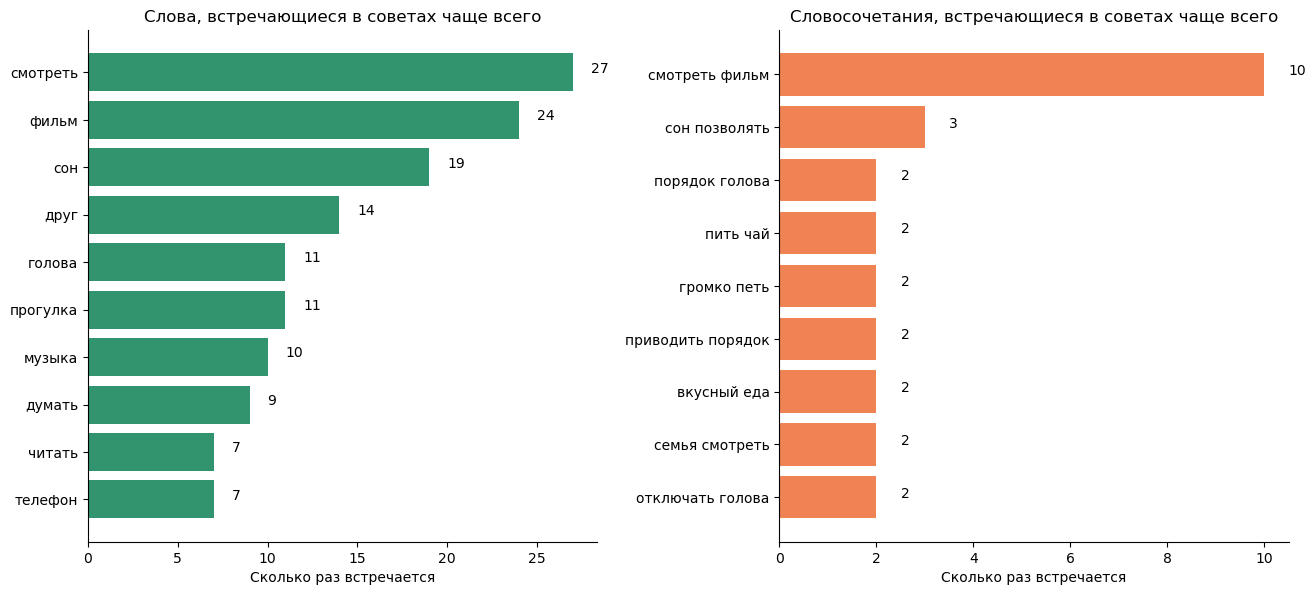

In [27]:
plot_ngrams(final['advice'])

Чтобы не заработаться и не выгореть, нужно отдыхать и приводить голову в порядок. Для большинства ответивших в этом помогает просмотр фильма, чтение книг, расслабляющая музыка, сон, прогулка, вкусная еда. Необязательно делать это одному - можно провести время вместе с семьёй или друзьями. 

И вы не забывайте отдыхать! :)